<a href="https://colab.research.google.com/github/ajaynain-eng/2D-to-3D-CNN-Pivotal-Teleradiology/blob/main/2D_to_3D_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
 import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive' # '/content'

In [2]:
!kaggle datasets download -d ymirsky/medical-deepfakes-lung-cancer

100% 5.99G/5.99G [02:09<00:00, 39.0MB/s]
100% 5.99G/5.99G [02:09<00:00, 49.6MB/s]


In [ ]:
!unzip \*.zip && rm *.zip  # unzip all zip files

In [ ]:
!pip install pydicom

In [ ]:
!pip install tensorflow_addons

In [1]:
# importing supporting libraries
import pandas as pd                    # to create and read data frame and series
import numpy as np                     # to work with array
from matplotlib import pyplot as plt   # to plot figures
import seaborn as sns                  # to plot interactive metric plot and heatmaps
import cv2                             # to read and show image
from skimage.transform import resize   # as we need to resize the image to reduce model complexity and get optimum accuracy
import scipy.linalg as linalg

from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score

import os
import warnings
import pydicom as dicom
import glob
import scipy.ndimage
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection


# importing required CNN algorithms, optimizers and activation function
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
#from keras.applications import VGG16
from keras import Sequential
from keras import layers
from keras.layers import Conv1D, Conv2D, Conv3D, MaxPool3D, ZeroPadding3D, Dropout, BatchNormalization
from keras.layers import Flatten, Dense, Input
from keras.layers import LeakyReLU
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD
from keras.models import Model
from keras import callbacks
from keras.metrics import Precision, Recall, RecallAtPrecision
# importing pretrained model VGG16 and VGG19
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import random_zoom, random_shear, random_shift, random_rotation
import time

from sklearn.preprocessing import MinMaxScaler
from skimage import measure
from skimage.transform import resize
from matplotlib.projections import Axes3D
from plotly.figure_factory import create_trisurf
from mpl_toolkits import mplot3d
from PIL import Image

tfa.metrics.RSquare(name = 'r_square')
# tfa.metrics.F1Score(name = 'f1_score')

Our first step is data cleaning.                                                
Lets crop the images to a standard size. A shape of (110,110) for every dicom image seems to be good.

In [15]:
def transform_to_hu(medical_image, image):
    intercept = medical_image.RescaleIntercept
    slope = medical_image.RescaleSlope
    hu_image = image * slope + intercept
    return hu_image

def window_image(image, window_center, window_width):
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    window_image = image.copy()
    window_image[window_image < img_min] = img_min
    window_image[window_image > img_max] = img_max
    return window_image

def crop_image(image, display=False):
# Create a mask with the background pixels
    mask = image == 0
# Find the lung area
    coords = np.array(np.nonzero(~mask))
    top_left = np.min(coords, axis=1)
    bottom_right = np.max(coords, axis=1)
# Remove the background
    croped_image = image[top_left[0]:bottom_right[0],
                         top_left[1]:bottom_right[1]]
    return croped_image

def no_crop(medical_img):         # changes the medical image in pixel array and returns the original image
    return medical_img.pixel_array

def crop_the_image_1(medical_img):     # crop the image corresponding to HU range for lungs
    temp_medical_img = medical_img
    temp_img = temp_medical_img.pixel_array
    hu_image = transform_to_hu(temp_medical_img,temp_img)
    lung_image = window_image(hu_image, -500, 1500)       # (-1000, 400), (-500, 1500)
    croped_img = crop_image(lung_image, display=False)
    return croped_img

def crop_the_image_2(medical_img):     # crop the image corresponding to HU range for lungs
    temp_medical_img = medical_img
    temp_img = temp_medical_img.pixel_array
    hu_image = transform_to_hu(temp_medical_img,temp_img)
    lung_image = window_image(hu_image, -1000, 400)       # (-1000, 400), (-500, 1500)
    croped_img = crop_image(lung_image, display=False)
    return croped_img

In [16]:
# img = crop_the_image_1(dicom.read_file('/content/CT_Scans/EXP1_blind/1003/1.dcm'))

In [17]:
def get_data(pid, crop_function):         #  corresponding to every patient, it selects 110 slices and crop them to standard size to give 3D and 2D image data
    files = glob.glob("/content/CT_Scans/EXP1_blind/"+ pid +"/*.dcm")
    slices = [dicom.read_file(i) for i in files]
    slices = sorted(slices, key=lambda s: s.SliceLocation)
    s = 0
    views = np.empty([110,110,110])
    x = (len(slices)-4)/109      # Select 110 slices
    for i in range(110):
        t = int(4+(x*i))
        try:
            t_img = crop_function(slices[t])
            t_img = resize(t_img, (110,110))
        except:
            t_img = crop_function(slices[t-1])
            t_img = resize(t_img, (110,110))
            s = s + 1
        views[:,:,i] = t_img          # 3D image array, CT scanes with shape (110,110,110)
        i += 1
    img_2d = views[55,:,:].T
    img_2d = img_2d[::-1]           # 2D image array, same as x-ray of chest with shape (110,110)
    print(s)     
    return views, img_2d

Next step is data preprocessing.                                                
Remove the highly correlated columns from the every slices and keep the remaining.

In [18]:
def get_correlation(data, threshold):     # prepares correlation metric for every slice and returns the correlated columns with correlation higher than a threshold
    corr_col = set()
    corr = data.corr()
    for i in range(len(corr.columns)):
        for j in range(i):
            if abs(corr.iloc[i,j]) > threshold:  #if abs(corr.iloc[i,j]) > threshold:
                corr_col.add(corr.columns[i])
    return corr_col

def get_uncorr_data(train_data, test_data, threshold):     # created the block of inter-correlated columns and make dataframe of these columns with correlation value
    start_time = time.time()
    correlated_block = dict()
    corr_columns = get_correlation(pd.DataFrame(train_data), threshold)
    temp_correlated_block = dict()


    corrmat = pd.DataFrame(train_data).corr()

    corrdata = corrmat.stack().sort_values(ascending = False)  #corrdata = corrmat.abs().stack().sort_values(ascending = False)

    corrdata = corrdata[corrdata > threshold]
    corrdata = corrdata[corrdata <= 1]
    corrdata = pd.DataFrame(corrdata).reset_index()
    corrdata.columns = ['feature1','feature2', 'value']

    grouped_column_list = []
    correlated_group_list = []
    for column in corrdata['feature1']:
        if column not in grouped_column_list:
            correlated_block_list = corrdata[corrdata.feature1 == column]
            grouped_column_list = grouped_column_list + list(correlated_block_list.feature2.unique()) + [column]
            correlated_group_list.append(correlated_block_list)         #  inter-correlated_block
    # if we drop all inter-correlated columns, data will lost its purity
    # so we will take out 1 column from every correlated block and would not drop it.
    # this will help in reducing the complexity of data without reducing its purity.
    important_columns = []
    for data in correlated_group_list:
        columns = list(data.feature1.unique()) + list(data.feature2.unique())
        important_columns.append(columns[0])                      # Selecting 1 column from every inter-correlated block
            

    new_to_drop = list(corr_columns - set(important_columns))

    l = new_to_drop
    
    # Also, as we will try to predict droped column from remaining. KNN seems to be good and time efficient algo.
    # As KNN predicts from nearby columns, so atleast 2 nearby columns from droped colunmns sholuld be there.
    # i.e. if 5th column is droped (3,4,6,7) should be there in available data.
    columns_to_drop = list()
    for i in l:
        if i not in [0,1,108,109]:
            if (i-1 not in columns_to_drop and i+1 not in columns_to_drop):     ####
                if (i-2 not in columns_to_drop and i+2 not in columns_to_drop):
                    columns_to_drop.append(int(i))

    for col in columns_to_drop:
        corr_col = corrdata[corrdata.feature1 == col]
        temp_correlated_block =  list(corr_col.feature2.unique())
        correlated_block[str(col)] = temp_correlated_block

    col_to_drop_df = pd.concat([corrdata, pd.Series(columns_to_drop, name = 'column_to_drop')], axis = 1)
    print(f'time for get_uncorr_data : {time.time() - start_time}')
    
    return col_to_drop_df, correlated_block

In [19]:
def get_cross_val_score(col_to_drop, y_0, correlated_block): 
    start_time = time.time()   
    rf_score_mean = list()      # diff_1 = droped_col[i] - droped_col[i-1]                             
    knn_score_mean = list()     # diff_2 = droped_col[i+1] - droped_col[i] - 1
    knn_neighbors = list()      # training_col = imp_col[diff_1:-diff_2]
    neighbors = 2
    estimators = 60

    # train the KNeighborsRegressor algo to make the predictions. The trained model can be saved to make predictions in future.
    temp_y = y_0.reshape((len(y_0)*110, 110))
    for key, value in correlated_block.items():
        #rf = RandomForestRegressor(n_estimators=40, random_state=0)   # + y_0[0][:,j:j+1]
        #rf_score_mean.append(cross_val_score(rf, pd.DataFrame(temp_y)[value], pd.DataFrame(temp_y)[int(key)]).mean()*100)
        #knn_time = time.time()
        knn_val_score = cross_val_score(KNeighborsRegressor(n_neighbors=2), pd.DataFrame(temp_y)[value], pd.DataFrame(temp_y)[int(key)])

        mean = knn_val_score.mean()*100
        m = list()
        n = list()
        p = list()
        if mean < 0.995:
            for k, o in enumerate([4, 6, 8, 10, 12]):           # selcet the best number pf neighbours if accuracy is less than 99.5%
                scr = cross_val_score(KNeighborsRegressor(n_neighbors=o), pd.DataFrame(temp_y)[value], pd.DataFrame(temp_y)[int(key)])
                m.append(o)
                n.append(scr.mean())
                p.append(scr)
            max_arg = np.array(n).argmax()
            knn_neighbors.append(m[max_arg])
            mean = n[max_arg]*100
        else:
            knn_neighbors.append(2)
        knn_score_mean.append(mean)

    # for i, j in enumerate(col_to_drop):
    #     rf = RandomForestRegressor(n_estimators=40, random_state=0)
    #     rf_score_mean.append(np.array(cross_val_score(rf, pd.DataFrame(y_0[0])[imp_col[i]] + y_0[0][:,j:j+1], pd.DataFrame(y_0[0])[j])).mean()*100)
    #     knn_val_score = cross_val_score(KNeighborsRegressor(n_neighbors=neighbors), pd.DataFrame(y_0[0])[imp_col[i]] + y_0[0][:,j:j+1], pd.DataFrame(y_0[0])[j])
    #     mean = knn_val_score.mean()*100
    #     m = list()
    #     n = list()
    #     p = list()
    #     if mean < 0.95:
    #         for k, o in enumerate([4, 6, 8, 10,12, 24]):
    #             scr = cross_val_score(KNeighborsRegressor(n_neighbors=o), pd.DataFrame(y_0[0])[imp_col[i]] + y_0[0][:, j:j+1], pd.DataFrame(y_0[0])[j])
    #             m.append(o)
    #             n.append(scr.mean())
    #             p.append(scr)
    #         max_arg = np.array(n).argmax()
    #         knn_neighbors.append(m[max_arg])
    #         mean = n[max_arg]*100
    #     else:
    #         knn_neighbors.append(2)
    #     knn_score_mean.append(mean)
    print(f'time for get_cross_val_score : {time.time() - start_time}')
    return  rf_score_mean, knn_score_mean, knn_neighbors

In [20]:
# now we will drop top 22 best correlated columns from the remaining columns selected as highly correlatewd based on the accuracy score made during prediction.
# The process is simple, sort the columns based on accuracy score made in descending oreder and drop the top 22. Now the droped 22 can be predicted with high accuracy

# After that it will return the data to be used for training.

def get_model_to_predict_col(y_train_0, y_test_0, y0, threshold):      # here y0 = y_train_0 + y_test_0   (i.e complete data)
    start_time = time.time()
    new_correlated_block = list()
    all_slices_knn_score = list()
    all_slices_rf_score = list()
    all_droped_col = list()
    all_algo = list()
    all_knn_neighbours = dict()
    len_sel_col = list()           
    len_droped_col = list()
    y_train = np.empty((len(y_train_0),110,88,110))
    y_test = np.empty((len(y_test_0),110,88,110))
    for s in range(0,110):
        print(f'slice {s} started......')
        y_0 = y_train_0[:,:,:,s]
        y_test0 = y_test_0[:,:,:,s]
        col_to_drop_df, correlated_block = get_uncorr_data(y_0[4], y_test0[4], threshold)                                                    # get_uncorr_data
        col_to_drop = list(col_to_drop_df.dropna().sort_values(by = 'value', ascending=False)['column_to_drop'])
        col_to_drop = [int(i) for i in col_to_drop]
        col_to_drop.sort()
        len_sel_col.append(len(col_to_drop))
        # imp_col = list()
        # for i in np.arange(2,108):
        #     if i in col_to_drop:
        #         imp_col.append([i-2,i-1,i+1,i+2])
 
        rf_score_mean, knn_score_mean, knn_neighbors = get_cross_val_score(col_to_drop, y0[:,:,:,s], correlated_block)         # get_cross_val_score 
        #score_df = pd.DataFrame({'col_to_drop' : col_to_drop, 'rf_score_mean' : rf_score_mean, 'knn_score_mean' : knn_score_mean})
        score_df = pd.DataFrame({'col_to_drop' : col_to_drop, 'knn_score_mean' : knn_score_mean})
        # if np.mean(score_df.knn_score_mean) > np.mean(score_df.rf_score_mean):
        #     scoring_algo = 'knn_score_mean' 
        #     all_knn_neighbours[str(s)] = knn_neighbors
        # else:        
        #     scoring_algo = 'rf_score_mean'

        # all_algo.append(scoring_algo)
        # droped_col = list(score_df.sort_values(by=scoring_algo, ascending=False)['col_to_drop'])[:22]
        droped_col = list(score_df.sort_values(by='knn_score_mean', ascending=False)['col_to_drop'])[:22]   # sorting in descending order and select top 22
        droped_col.sort()
        temp_correlated_block = dict()
        for col in droped_col:
            if str(col) in correlated_block.keys():
                temp_correlated_block[str(col)] = correlated_block[str(col)]
        new_correlated_block.append(temp_correlated_block)
        all_droped_col.append(droped_col)
        print(f'columns selected to drop : {len(col_to_drop)} and   {len(droped_col)} are droped')
        all_slices_knn_score.append(knn_score_mean)
        all_slices_rf_score.append(rf_score_mean)

        #y_train[:,:,:s] = pd.DataFrame(y_0).drop(droped_col, axis = 1)
        #y_test[:,:,:s] = pd.DataFrame(y_test0).drop(droped_col, axis = 1)
        for z in range(len(y_train_0)):
            y_train[z,:,:,s] = np.array(pd.DataFrame(y_0[z]).drop(droped_col, axis = 1)).reshape(110,88)
        for z in range(len(y_test0)):
            y_test[z,:,:,s] = np.array(pd.DataFrame(y_test0[z]).drop(droped_col, axis = 1)).reshape(110,88)

        print(f'total time required : {time.time() - start_time}', '\n')
    return y_train, y_test, all_slices_knn_score, all_slices_rf_score, all_droped_col, all_algo, all_knn_neighbours, new_correlated_block

In [21]:
# Image preprocessing
# x_0 = 255 - x_0
# y_0 = 255 - y_0
# x_1 = 255 - x_1
# y_1 = 255 - y_1
def get_background_removed_data(x):   # here x is slices
  temp_x = np.empty((110,88))
  temp_y = np.empty((110,88,110))
  scaler = MinMaxScaler()
  # for s,i in enumerate(x):
  for j in range(110):
    img = x[:,:,j]
    # Gaussian blur
    img = scaler.fit_transform(img)
    img = img/(img.max()/255.0)
    img = cv2.GaussianBlur(img, (5,5), 0) # cv2.BORDER_DEFAULT) 

    '''# get the image histogram
    bins_num = 256
    hist, bin_edges = np.histogram(img, bins = bins_num)

    # get normalized histogram if required
    # if is_normalized:
    #   hist = np.divide(hist.ravel(), hist.max())

    # calculate centre of bins
    bin_mids = (bin_edges[:-1] + bin_edges[1:])/2.0

    # iterate over all thresholds (indices) and get the probablitie w1(t), w2(t)
    weight1 = np.cumsum(hist)
    weight2 = np.cumsum(hist[::-1])[::-1]

    # get the class means mu0(t)
    mean1 = np.cumsum(hist*bin_mids)/weight1

    # get the class means mu1(t)
    mean2 = (np.cumsum(hist*bin_mids[::-1])/weight1[::-1])[::-1]

    inter_class_variance = weight1[:-1]*weight2[1:]*(mean1[:-1] - mean2[1:])**2

    # maximize the inter_class_variance function value
    index_of_max_val = np.argmax(inter_class_variance)
    threshold = bin_mids[:-1][index_of_max_val]
    # print("Otsu's algorithum implementation thresholding result : ", threshold)'''
    ostu_threshold, image_result = cv2.threshold(img, 175, 255, cv2.THRESH_BINARY )
    temp_y[:,:,j] = image_result
  # temp_x[:,:] = temp_y[s][55,:,:].T
  return temp_y

In [ ]:
# as the model requires huge amount of data for training 

# after we have cleaned data, we will perform data augmentation

# due to liminted hardware, we can affort to creat 10 new images from 1 image.

# This function will return the well maintained training data afer performing Augmentation

def get_augmented_data(len_train_data, y_aug, true):         # len_train_data = 65
    x = np.empty((len_train_data*10, 110,88))
    y = np.empty((len_train_data*10, 110,88,110))
    s = 0
    k = 0
    for i in y_aug:    # i.shape = 7150*110*110*1        65*110 = 7150
        k +=1
        print(k)
        s1 = 0
        s2 = 110
        for j in range(65):
            temp_y = np.empty((110,88,110))          
            for m in range(110):                 # temp_x.shape = [110,110,110]         
                count = j*110 + m
                img = i[count].reshape(110,88)
                if true:                        # the step converts the image in two type of pixel array. if pixel_value < threshold => change the pixel value to 0 else to 255.
                  scaler = MinMaxScaler()       # Means this step change the pixel values just in 0 and 255 mean perfact white or perfect black.
                  img = scaler.fit_transform(img)
                  img = img/(img.max()/255.0)   # to make the pixel value range between (0,255)
                  img = cv2.GaussianBlur(img, (5,5), cv2.BORDER_DEFAULT)    # make the image littlebit bullered, means keep only highly detailed pixels unchanged
                  ostu_threshold, img_result = cv2.threshold(img, 175, 255, cv2.THRESH_BINARY)   # img_result is resulted image having just two pixel values eighter 0,255
                  temp_y[:,:,m] = img_result
                else:
                  temp_y[:,:,m] = img         # if you have assign true = False, the above operation is not carried out. It just arranges the slices 
            # temp_y = i[s1:s2].reshape(110,110,110)
            y[j*k,:,:,:] = temp_y
            s1 = s1+110
            s2 = s2+110
            x_temp = temp_y[55,:,:].T
            x[s] = x_temp[::-1]
            s += 1
        if k >= 10:
            break
    return x, y

In [ ]:
def r_squared(x,y):
  x = np.array(x)
  y = np.array(y)
  slope, intercept, r_value, p_value, std_error = scipy.stats.linregress(x,y)
  r_value = tf.TensorArray(r_value)
  return r_value**2

In [ ]:
# functions to plot the learning curve
def plot_learning_curve(model_history):   
    plt.figure(figsize=(15,6))
    plt.plot(model_history.history['accuracy'], color = 'green', label = 'train_accuracy')                         # np.arange(0,epochs),
    plt.plot(model_history.history['loss'], color = 'red', label = 'train_loss')
    plt.plot(model_history.history['val_accuracy'], color = 'blue', label = 'test_accuracy')
    plt.plot(model_history.history['val_loss'], color = 'black', label = 'test_loss')
    plt.grid()
    plt.legend()
    plt.xlabel('no. of epochs')
    plt.ylabel('accuracy and loss')
    plt.legend(loc = 'lower right')

def plot_accuracy_curve(model_history):    
    plt.figure(figsize=(15,6))
    plt.plot(model_history.history['accuracy'], color = 'green', label='accuracy')
    plt.plot(model_history.history['val_accuracy'], color = 'red', label = 'test accuracy')
    plt.legend()
    plt.grid()
    plt.legend(loc = 'lower right')

def plot_loss_curve(model_history):
    plt.figure(figsize = (20,7))
    plt.plot(model_history.history['loss'], color = 'green', label = 'train_loss')
    plt.plot(model_history.history['val_loss'], color = 'red', label = 'val_loss')
    plt.legend()
    plt.grid()

In [ ]:
patients_id = os.listdir('/content/CT_Scans/EXP1_blind')

In [ ]:
df = pd.read_csv('/content/Response EXP1 - AI_patients.csv')
fm_id = list(df[df['type'] == 'FM']['id'].values)
fb_id = list(df[df['type'] == 'FB']['id'].values)
tm_id = list(df[df['type'] == 'TM']['id'].values)
tb_id = list(df[df['type'] == 'TB']['id'].values)
fm_id = [str(i) for i in fm_id]
fb_id = [str(i) for i in fb_id]
tm_id = [str(i) for i in tm_id]
tb_id = [str(i) for i in tb_id]

In [ ]:
f = patients_id.copy()
g2d_0 = np.zeros((len(f),110,110))
views_0 = np.zeros((len(f),110,110,110))
fcount_0 = []
for i,j in enumerate(f):
    print(i)
    img_3d, img_2d = get_data(j, no_crop)
    g2d_0[i] = img_2d
    views_0[i] = img_3d
    #views_0[i] = selected_slices(j, no_crop)
x_0 = g2d_0
y_0 = views_0
np.save('/content/Data_out_0.npy', views_0)              # Temprory storing the data in drive
np.save('/content/Data_in_0.npy', g2d_0)

In [20]:
f = patients_id.copy()
g2d_1 = np.zeros((80,110,110))
views_1 = np.zeros((80,110,110,110))
for i,j in enumerate(f):
    print(i)
    img_3d, img_2d = get_data(j, crop_the_image_1)
    g2d_1[i] = img_2d
    views_1[i] = img_3d
    #views_0[i] = selected_slices(j, no_crop)
x_1 = g2d_1
y_1 = views_1
np.save('Data_out_1.npy', views_1)
np.save('Data_in_1.npy', g2d_1)

0
1
1
1
2
1
3
1
4
1
5
1
6
0
7
1
8
1
9
1
10
1
11
1
12
1
13
1
14
1
15
1
16
1
17
1
18
1
19
1
20
1
21
1
22
0
23
1
24
1
25
1
26
1
27
1
28
0
29
1
30
1
31
1
32
1
33
0
34
1
35
1
36
1
37
1
38
1
39
1
40
1
41
1
42
1
43
1
44
1
45
1
46
1
47
1
48
1
49
1
50
1
51
0
52
1
53
1
54
1
55
1
56
1
57
1
58
1
59
1
60
1
61
1
62
1
63
1
64
1
65
1
66
1
67
1
68
1
69
1
70
1
71
1
72
0
73
1
74
1
75
1
76
1
77
1
78
1
79
1


In [ ]:
# x_0 = np.load('/content/Data_in_0.npy')
# y_0 = np.load('/content/Data_out_0.npy')
# x_1 = np.load('/content/Data_in_1.npy')
# y_1 = np.load('/content/Data_out_1.npy')

In [22]:
'''# img = dicom.read_file('/content/CT_Scans/EXP1_blind/1003/1.dcm').pixel_array
img = y_0[5,:,:,0]
plt.imshow(img, cmap='gray')'''

"# img = dicom.read_file('/content/CT_Scans/EXP1_blind/1003/1.dcm').pixel_array\nimg = y_0[5,:,:,0]\nplt.imshow(img, cmap='gray')"

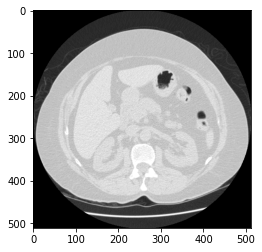

In [23]:
img = crop_the_image_1(dicom.read_file('/content/CT_Scans/EXP1_blind/1003/1.dcm'))
plt.imshow(img, cmap = 'gray')

the below code and output shows the effect of assigning true = True in the function get_augmented_data(). The input is above image and the output is the image below

(-0.5, 510.5, 510.5, -0.5)

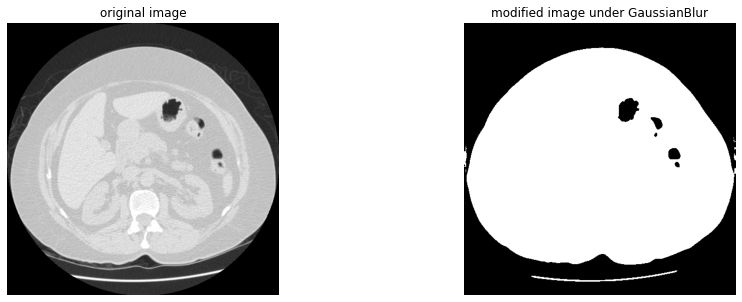

In [25]:
# Image preprocessing
# x_0 = 255 - x_0
# y_0 = 255 - y_0
# x_1 = 255 - x_1
# y_1 = 255 - y_1
# img = dicom.read_file('/content/CT_Scans/EXP1_blind/1003/10.dcm').pixel_array
img_o = crop_the_image_1(dicom.read_file('/content/CT_Scans/EXP1_blind/1003/1.dcm'))
scaler = MinMaxScaler()
# Gaussian blur
img = scaler.fit_transform(img_o)
img = img/(img.max()/255.0)
# img = 255-img
img = cv2.GaussianBlur(img, (5,5), cv2.BORDER_DEFAULT) 

      # get the image histogram

# the below code in string format is just to get the threshold value. The threshold value = 175 found to hold good. So i am not calculating it qagain and again
'''bins_num = 256
hist, bin_edges = np.histogram(img, bins = bins_num)

      # get normalized histogram if required
      # if is_normalized:
      #   hist = np.divide(hist.ravel(), hist.max())

      # calculate centre of bins
bin_mids = (bin_edges[:-1] + bin_edges[1:])/2.0

      # iterate over all thresholds (indices) and get the probablitie w1(t), w2(t)
weight1 = np.cumsum(hist)
weight2 = np.cumsum(hist[::-1])[::-1]

      # get the class means mu0(t)
mean1 = np.cumsum(hist*bin_mids)/weight1

      # get the class means mu1(t)
mean2 = (np.cumsum(hist*bin_mids[::-1])/weight1[::-1])[::-1]     
inter_class_variance = weight1[:-1]*weight2[1:]*(mean1[:-1] - mean2[1:])**2

      # maximize the inter_class_variance function value
index_of_max_val = np.argmax(inter_class_variance)
threshold = bin_mids[:-1][index_of_max_val]'''
      # print("Otsu's algorithum implementation thresholding result : ", threshold)
ostu_threshold, image_result = cv2.threshold(img, 175, 255, cv2.THRESH_BINARY )
fig = plt.figure(figsize = (15,5))
a = fig.add_subplot(1,2,1)
a.set_title('original image')
plt.imshow(img_o, cmap = 'gray')
plt.axis('off')
a = fig.add_subplot(1,2,2)
a.set_title('modified image under GaussianBlur')
plt.imshow(image_result, cmap = 'gray')
plt.axis('off')

In [25]:
# threshold*350

In [26]:
# plt.imshow(image_result, cmap = 'gray')

In [27]:
'''scaler = MinMaxScaler()
# Gaussian blur
img = scaler.fit_transform(img)
print(img.min(), img.max())
img = img/(img.max()/255.0)
print(img.min(), img.max())
# Set total number of bins in the histogram
bins_num = 256
# Get the image histogram
hist, bin_edges = np.histogram(img, bins=bins_num)
# Get normalized histogram if it is required
# if is_normalized:
#   hist = np.divide(hist.ravel(), hist.max())

# Calculate centers of bins

bin_mids = (bin_edges[:-1] + bin_edges[1:]) / 2.
# Iterate over all thresholds (indices) and get the probabilities w1(t), w2(t)
weight1 = np.cumsum(hist)
weight2 = np.cumsum(hist[::-1])[::-1]
# Get the class means mu0(t)
mean1 = np.cumsum(hist * bin_mids) / weight1
# Get the class means mu1(t)
mean2 = (np.cumsum((hist * bin_mids)[::-1]) / weight2[::-1])[::-1]
inter_class_variance = weight1[:-1] * weight2[1:] * (mean1[:-1] - mean2[1:]) ** 2
# Maximize the inter_class_variance function val
index_of_max_val = np.argmax(inter_class_variance)
threshold = bin_mids[:-1][index_of_max_val]
print("Otsu's algorithm implementation thresholding result: ", threshold)'''

'scaler = MinMaxScaler()\n# Gaussian blur\nimg = scaler.fit_transform(img)\nprint(img.min(), img.max())\nimg = img/(img.max()/255.0)\nprint(img.min(), img.max())\n# Set total number of bins in the histogram\nbins_num = 256\n# Get the image histogram\nhist, bin_edges = np.histogram(img, bins=bins_num)\n# Get normalized histogram if it is required\n# if is_normalized:\n#   hist = np.divide(hist.ravel(), hist.max())\n\n# Calculate centers of bins\n\nbin_mids = (bin_edges[:-1] + bin_edges[1:]) / 2.\n# Iterate over all thresholds (indices) and get the probabilities w1(t), w2(t)\nweight1 = np.cumsum(hist)\nweight2 = np.cumsum(hist[::-1])[::-1]\n# Get the class means mu0(t)\nmean1 = np.cumsum(hist * bin_mids) / weight1\n# Get the class means mu1(t)\nmean2 = (np.cumsum((hist * bin_mids)[::-1]) / weight2[::-1])[::-1]\ninter_class_variance = weight1[:-1] * weight2[1:] * (mean1[:-1] - mean2[1:]) ** 2\n# Maximize the inter_class_variance function val\nindex_of_max_val = np.argmax(inter_class_varia

In [28]:
'''otsu_threshold, image_result = cv2.threshold(img, threshold, 255.0, cv2.THRESH_BINARY)

print("Obtained threshold: ", otsu_threshold)'''

'otsu_threshold, image_result = cv2.threshold(img, threshold, 255.0, cv2.THRESH_BINARY)\n\nprint("Obtained threshold: ", otsu_threshold)'

In [29]:
'''plt.imshow(image_result, cmap = 'gray')'''

"plt.imshow(image_result, cmap = 'gray')"

In [30]:
x_train_0 = x_1[:65]
x_test_0 = x_1[65:]
y_train_0 = y_1[:65]
y_test_0 = y_1[65:]

#x0 = x_train_0[:,1,:]
#y0 = y_train_0[:,:,:,1]          # temp_x = x_0[:][:,1,:], temp_y = y_0[:][:,:,:,1]
#x_test0 = x_test_0[:,1,:]
#y_test0 = y_test_0[:,:,:,1]
x_train_1 = x_1[:65]
x_test_1 = x_1[65:]
y_train_1 = y_1[:65]
y_test_1 = y_1[65:]

#x1 = x_train_1[:,1,:]
#y1 = y_train_1[:,:,:,1]
#x_test1 = x_test_1[:,1,:]
#y_test1 = y_test_1[:,:,:,1]

In [ ]:
y_train, y_test,all_slices_knn_score, all_slices_rf_score, all_droped_col, all_algo, all_knn_neighbours, new_correlated_block = get_model_to_predict_col(y_train_0, y_test_0, y_0, 0.92)

In [ ]:
y_train.shape, y_test.shape

In [ ]:
del y_train_0, y_test_0, y_0, y_train_1, y_test_1, y_1
del all_slices_knn_score, all_slices_rf_score, all_algo, all_knn_neighbours, new_correlated_block

In [ ]:
np.save('y_train.npy', y_train)
np.save('y_test.npy', y_test)
np.save('all_droped_col', all_droped_col)

In [ ]:
y_train = np.load('/content/y_train.npy')
y_test = np.load('/content/y_test.npy')

In [ ]:
new_y = np.empty((65*110,110,88))
s1 = 0
s2 = 110
for i in range(65):
    for j in range(110):
        new_y[s1+j,:,:] = y_train[i,:,:,j]
    s1 = s1+110

new_y = new_y.reshape(65*110,110,88,1)

In [ ]:
training_data_gen = ImageDataGenerator(#target_size = (110,110),
                                       rotation_range = 4, 
                                       width_shift_range = 0.0,
                                       height_shift_range = 0.0,
                                       shear_range = 0.1,
                                       zoom_range = 0.02, 
                                       #mode = 'binary',
                                       horizontal_flip = False)

In [ ]:
img_aug = training_data_gen.flow(x= new_y,  batch_size=65*110, shuffle=False)
x_train_in, y_train_in = get_augmented_data(len(x_train_0), img_aug, False)

In [ ]:
np.save('x_train_in.npy', x_train_in)
np.save('y_train_in.npy', y_train_in)

In [ ]:
fig, axe = plt.subplots(5,13, sharex=True, sharey=True, figsize = (25,7))

for i in range(5):
    for j in range(13):
        s = (i*13 + j)*10
        axe[i,j].imshow(x_train_in[s])

In [ ]:
fig, axe = plt.subplots(5,13, sharex=True, sharey=True, figsize = (25,7))

for i in range(5):
    for j in range(13):
        s = (i*13 + j)*10
        axe[i,j].imshow(y_train_in[s][:,:,55])

In [42]:
del x_train_in, y_train_in

In [ ]:
# y_train = np.load('/content/y_train_in.npy')

In [ ]:
img_aug = training_data_gen.flow(x= new_y,  batch_size=65*110, shuffle=False)
x_train_in_new, y_train_in_new = get_augmented_data(len(x_train_0), img_aug, True)

In [ ]:
np.save('x_train_in_new.npy', x_train_in_new)
np.save('y_train_in_new.npy', y_train_in_new)

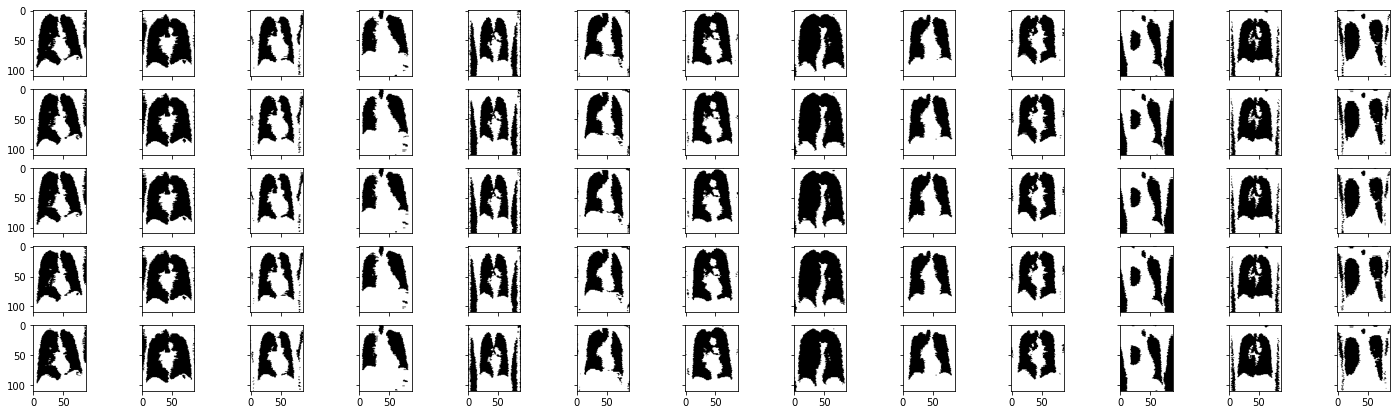

In [60]:
fig, axe = plt.subplots(5,13, sharex=True, sharey=True, figsize = (25,7))

for i in range(5):
    for j in range(13):
        s = (i*13 + j)*10
        axe[i,j].imshow(x_train_in_new[s], cmap = 'gray')

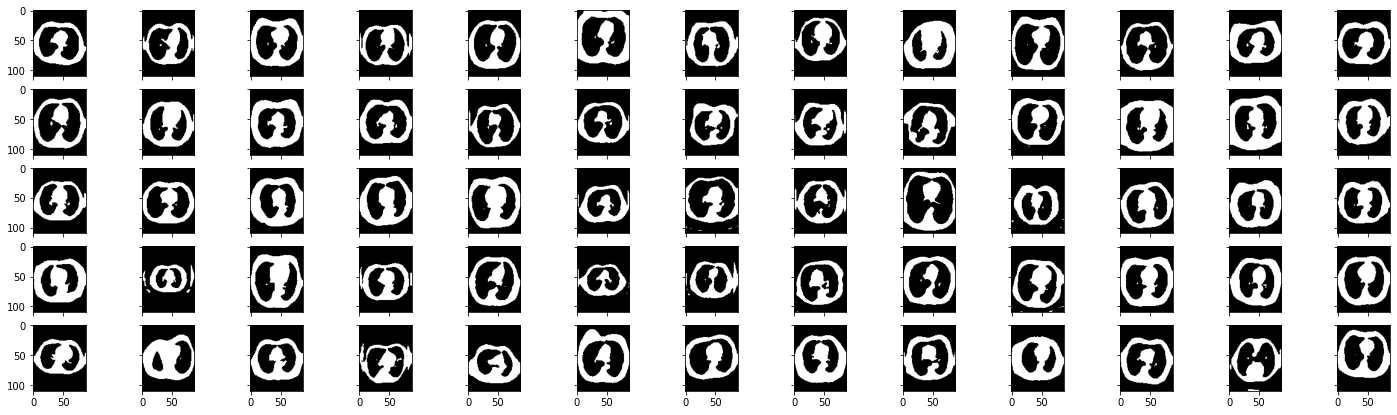

In [62]:
fig, axe = plt.subplots(5,13, sharex=True, sharey=True, figsize = (25,7))

for i in range(5):
    for j in range(13):
        s = (i*13 + j)*10
        axe[i,j].imshow(y_train_in_new[s][:,:,55], cmap = 'gray')

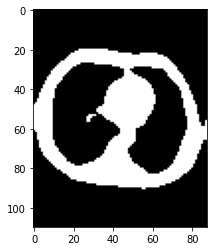

In [66]:
plt.imshow(y_train_in_new[0,:,:,50], cmap = 'gray')

In [ ]:
# now we are certain that data afer augmentation is OK as all the images ploted here seems to be good and look like the available ones

In [ ]:
all_droped_col = np.load('all_droped_col.npy')
len(all_droped_col)

In [ ]:
x_test = np.empty((15,110,88))
for s,i in enumerate(x_test_0):
  x_test[s] = cv2.resize(i, (88,110), interpolation = cv2.INTER_AREA)

Here i am taking the kerner_size = (1,1) because it become easy to optimize small filters then larger one like (3,3) or (5,5) with less data as in our case.

Further while reversing the process of code execution, it becomes easier with small kernel size

In [3]:
vgg_16 = VGG16(input_shape=(110,110,3), weights='imagenet', include_top=False)
for layer in vgg_16.layers[:10]:
    layer.trainable = False
input = vgg_16.layers[:5]
model = Sequential()
model.add(Conv2D(filters=1, kernel_size=(1,1), padding='same', kernel_initializer='he_uniform', activation='relu', input_shape = (110,88,1)))    #LeakyReLU(alpha=1)
model.add(keras.layers.experimental.preprocessing.RandomRotation(0.001))
model.add(Conv2D(filters=3, kernel_size=(1,1), padding="same", kernel_initializer='he_uniform', activation='relu'))
model.add(input[0])
model.add(input[1])
model.add(input[2])
#model.add(Conv2D(filters=3, kernel_size=(3,3), padding="same", kernel_initializer='he_uniform', activation='relu'))
#model.add(Conv2D(filters=3, kernel_size=(3,3), padding="same", kernel_initializer='he_uniform', activation='relu'))
model.add(Conv2D(filters=8, kernel_size=(1,1), padding="same", kernel_initializer='he_uniform', activation='relu'))
model.add(Conv2D(filters=16, kernel_size=(1,1), padding="same", kernel_initializer='he_uniform', activation='relu'))
model.add(Conv2D(filters=16, kernel_size=(1,1), padding="same", kernel_initializer='he_uniform', activation='relu'))
model.add(Conv2D(filters=32, kernel_size=(1,1), padding="same", kernel_initializer='he_uniform', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(1,1), padding="same", kernel_initializer='he_uniform', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(1,1), padding="same", kernel_initializer='he_uniform', activation='relu'))
model.add(Conv2D(filters=110, kernel_size=(1,1), padding="same", kernel_initializer='he_uniform', activation='relu'))
model.add(Conv2D(filters=110, kernel_size=(1,1), padding="same", kernel_initializer='he_uniform', activation='relu'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 110, 88, 1)        2         
_________________________________________________________________
module_wrapper (ModuleWrappe (None, 110, 88, 1)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 110, 88, 3)        6         
_________________________________________________________________
input_1 (InputLayer)         multiple                  0         
_________________________________________________________________
block1_conv1 (Conv2D)        multiple                  1792      
_________________________________________________________________
block1_conv2 (Conv2D)        multiple                  36928     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 110, 88, 8)        5

In [4]:
#training_data_gen.fit(x)        # Adam(learning_rate=0.0008)
model.compile(loss = 'mape', optimizer= Adam(learning_rate= 0.0001, beta_1 = 0.9, beta_2=0.999, amsgrad=True), metrics = ['mse'])
# model.compile(loss = 'categorical_crossentropy', optimizer= SGD(learning_rate= 0.0001), metrics = ['accuracy', 'mean_squared_error'])
history = model.fit(x_train_in_new.reshape(650, 110, 88, 1), y_train_in_new, batch_size=16, validation_data=(x_train_in_new[600:].reshape(50, 110, 88,1), y_train_in_new[600:]), epochs = 50)

# history = model.fit(x_train_in.reshape(650,110,88,1), y_train_in[:,:,:,:16], batch_size=33, validation_data=(x_test_0[:,:,:88].reshape(15,110,88,1), y_test[:,:,:,:16]), epochs = 30)

Epoch 1/50
41/41 [==============================] - 87s 2s/step - loss: 226615017.1429 - mse: 12593.5771 - val_loss: 132079624.0000 - val_mse: 2505.8562
Epoch 2/50
41/41 [==============================] - 70s 2s/step - loss: 91500538.6667 - mse: 12481.5927 - val_loss: 60616368.0000 - val_mse: 2507.3052
Epoch 3/50
41/41 [==============================] - 71s 2s/step - loss: 42833263.2381 - mse: 12248.4987 - val_loss: 26853212.0000 - val_mse: 2507.9998
Epoch 4/50
41/41 [==============================] - 71s 2s/step - loss: 18217887.0952 - mse: 12380.6891 - val_loss: 9589334.0000 - val_mse: 2508.3584
Epoch 5/50
41/41 [==============================] - 71s 2s/step - loss: 5832877.4881 - mse: 12876.1778 - val_loss: 1639089.2500 - val_mse: 2508.5120
Epoch 6/50
41/41 [==============================] - 71s 2s/step - loss: 987352.1786 - mse: 12540.6583 - val_loss: 431586.5625 - val_mse: 2508.5376
Epoch 7/50
41/41 [==============================] - 71s 2s/step - loss: 379191.6332 - mse: 11906.07

Now i am building a model which wolud be trained to predict X-Ray images with a hope that it is easier to train the model for making prediction on (110,110,110) to (110,110) shape. As now it will predict 1 pixel corresponding to 110 pixels which makes the training less complex

In [9]:
# In this approach of model building, model have to predict 110 pixels corresponding to 1 pixel. So the process seems to be very complex.
model = Sequential()
model.add(Conv2D(filters=110, kernel_size=(1,1), padding='same', kernel_initializer='he_uniform', activation='linear', input_shape = (110,88,110)))    
model.add(Conv2D(filters=64, kernel_size=(1,1), padding="same", kernel_initializer='he_uniform', activation='linear'))
model.add(Conv2D(filters=64, kernel_size=(1,1), padding="same", kernel_initializer='he_uniform', activation='linear'))
model.add(Conv2D(filters=32, kernel_size=(1,1), padding="same", kernel_initializer='he_uniform', activation='linear'))
model.add(Conv2D(filters=32, kernel_size=(1,1), padding="same", kernel_initializer='he_uniform', activation='linear'))
model.add(Conv2D(filters=16, kernel_size=(1,1), padding="same", kernel_initializer='he_uniform', activation='linear'))
model.add(Conv2D(filters=16, kernel_size=(1,1), padding="same", kernel_initializer='he_uniform', activation='linear'))
model.add(Conv2D(filters=8, kernel_size=(1,1), padding="same", kernel_initializer='he_uniform', activation='linear'))
model.add(Conv2D(filters=8, kernel_size=(1,1), padding="same", kernel_initializer='he_uniform', activation='linear'))
model.add(Conv2D(filters=3, kernel_size=(1,1), padding="same", kernel_initializer='he_uniform', activation='linear'))
model.add(Conv2D(filters=3, kernel_size=(1,1), padding="same", kernel_initializer='he_uniform', activation='linear'))
# model.add(input[0])
# model.add(input[1])
# model.add(input[2])
model.add(Conv2D(filters=1, kernel_size=(1,1), padding="same", kernel_initializer='he_uniform', activation='linear'))
model.add(Conv2D(filters=1, kernel_size=(1,1), padding="same", kernel_initializer='he_uniform', activation='linear'))
# model.add(Flatten())
# model.add(Dense(110, activation='linear'))
# model.add(Dense(110, activation='linear'))
# model.add(Dense(110, activation='linear'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 110, 88, 110)      12210     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 110, 88, 64)       7104      
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 110, 88, 64)       4160      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 110, 88, 32)       2080      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 110, 88, 32)       1056      
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 110, 88, 16)       528       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 110, 88, 16)      

In [13]:
model.compile(loss = 'mape', optimizer= Adam(learning_rate= 0.001), metrics = ['mse', 'accuracy'])     
history = model.fit(y_train_in_new, x_train_in_new.reshape(650, 110, 88, 1), batch_size=16, validation_data=(y_train_in_new[600:].reshape(50,110,88,110), x_train_in_new[600:].reshape(50,110,88,1)), epochs = 50)      

Epoch 1/50
41/41 [==============================] - 37s 860ms/step - loss: 2084288347.4286 - mse: 42507.9581 - accuracy: 0.2975 - val_loss: 6258628.0000 - val_mse: 42172.2461 - val_accuracy: 0.3514
Epoch 2/50
41/41 [==============================] - 34s 819ms/step - loss: 16296748.7381 - mse: 41739.1820 - accuracy: 0.3580 - val_loss: 772416.5000 - val_mse: 42169.5039 - val_accuracy: 0.3515
Epoch 3/50
41/41 [==============================] - 34s 831ms/step - loss: 4380298.0357 - mse: 41446.2078 - accuracy: 0.3626 - val_loss: 788562.5625 - val_mse: 42169.3398 - val_accuracy: 0.3515
Epoch 4/50
41/41 [==============================] - 33s 816ms/step - loss: 3119776.2083 - mse: 41591.8051 - accuracy: 0.3604 - val_loss: 426520.1562 - val_mse: 42169.3906 - val_accuracy: 0.3515
Epoch 5/50
41/41 [==============================] - 34s 827ms/step - loss: 2496009.7679 - mse: 41754.1568 - accuracy: 0.3579 - val_loss: 149682.0938 - val_mse: 42169.3828 - val_accuracy: 0.3515
Epoch 6/50
41/41 [=======

As we build a model to predict X-Ray images from 3D array of CT scane images. But we have to do the reverse. Lets do the reverse.

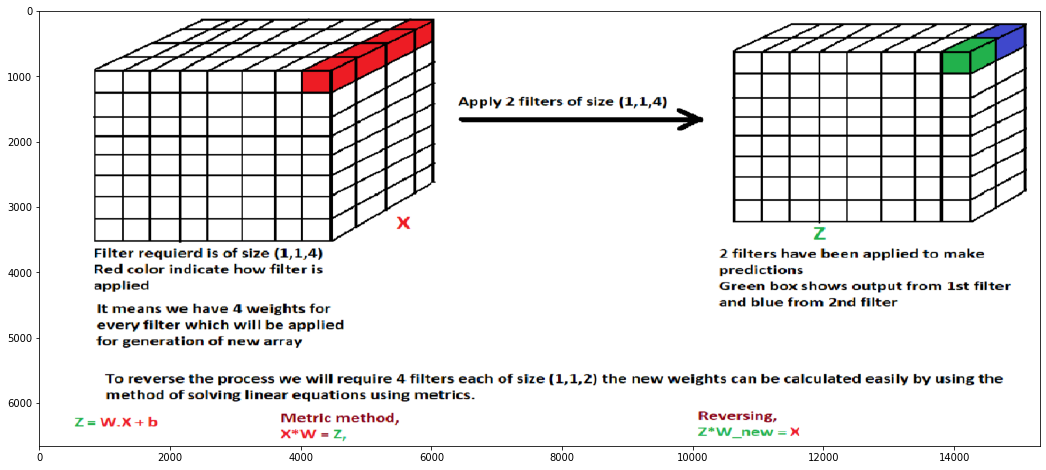

In [2]:
plt.figure(figsize = (20,8))
temp = plt.imread('/content/drive/MyDrive/2D_to_3D.png')
plt.imshow(temp)

In [ ]:
model_weights = model.weights   # take the weights from the trained model

# the weights taken directly have contain some unwanted string formated material
# Lets append just weights and biases to list
lst = list()
for i in model_weights:
    lst.append(np.array(i)) 
    
np.save('/content/model_weights.npy', lst)    # saving temperaly in cloud storage.
lst = np.load('/content/model_weights.npy', allow_pickle=True)

# now lets seperate the weights and biases and appending them in seperate list
weights = list()
bias = list()
for i in range(0,len(lst),2):
    weights.append(lst[i])
    bias.append(lst[i+1])

In [ ]:
# The formulization involved in the  the process is as follpw
# z = w.x + b

# so we need to find new metrics formed at every step. After that we will be able to calculate weights in reverse process

A = y_test[0]
list_A = list()
for i in np.arange(0,len(lst), 2):
    w = lst[i]
    b = lst[i+1]
    temp_shape = [110,88]
    temp_shape.append(w.shape[3])
    temp_A = np.empty(tuple(temp_shape))
    for j in range(w.shape[3]):
        # C_shape = [110,88]
        # C_shape.append(w.shape[2])
        C = np.empty((110,88))
        for k in range(w.shape[2]):
            C += np.multiply(A[:,:,k].reshape(110,88), w[:,:,k,j].reshape(1,1)).reshape(110,88)
        temp_A[:,:,j] = C + b[j]
        temp_A[temp_A<0] = 0
    list_A.append(temp_A)
    A = temp_A

In [ ]:
# calculate the weights, bias for reverse process

new_weights = list() 
new_bias = bias[::-1]   
new_list_A = list_A[::-1]
for i in range(len(new_list_A)-1):
    A = new_list_A[i][:new_list_A[i].shape[2],0,:] - new_bias[i]
    A_1_shape = list(new_list_A[i+1].shape)
    temp_shape = [1,1]
    temp_shape.append(new_list_A[i].shape[2])
    temp_shape.append(A_1_shape[2])
    print(temp_shape)
    #temp_shape = (list(new_list_A[i].shape)[2], list(A_1_shape)[2])
    temp_w = np.empty(tuple(temp_shape))
    for j in range(A_1_shape[2]):
        B = (new_list_A[i+1][:new_list_A[i].shape[-1],0,j] - new_bias[i+1][j])    # .reshape(110,1)
        # B = new_list_A[i+1][:,0,j].reshape(110,1)
        print(A.shape, B.shape)
        C = np.linalg.solve(A,B).reshape(1,1,new_list_A[i].shape[2])
        print(C.shape)
        temp_w[:,:,:,j] = C
    new_weights.append(temp_w)
    print(temp_w.shape, new_bias[i+1].shape)
    print('\n')

In [ ]:
# make the prediction
A = x[0][:,:88,:1]
for i in range(len(new_weights)):
    temp_shape = [110,88]
    temp_shape.append(new_weights[i].shape[-1])
    A_new = np.empty(tuple(temp_shape))
    for j in range(A_new.shape[-1]):
        temp_A = np.empty((110,88,1))
        for k in range(A.shape[-1]):
            print(A[:,:,k].shape, new_weights[i][0,0,:,k].shape)
            temp_A += np.multiply(A[:,:,k], new_weights[i][1,1,:,k])
            print(temp_A.shape)
    A_new[:,:,j] = temp_A - new_bias[i]
    A = A_new

These further steps are for reloading od saved data as the the notebook gets crashed due to limited hardware.

In [ ]:
x_0 = np.load('/content/Data_in_0.npy')
# y_0 = np.load('/content/Data_out_0.npy')

# x_train_0 = x_0[:65]
x_test_0 = x_0[65:]
# y_train_0 = y_0[:65]
# y_test_0 = y_0[65:]
# del x_0, y_train_0, y_test_0, y_0

# y_train = np.load('/content/y_train.npy')
y_test = np.load('/content/y_test.npy')

y_train_in = np.load('/content/y_train_in.npy')
x_train_in = np.load('/content/x_train_in.npy')

In [2]:
y_train_in_new = np.load('/content/y_train_in_new.npy')
x_train_in_new = np.load('/content/x_train_in_new.npy')